# Reset

In [4]:
%reset -f

# Data split

In [5]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import datetime

In [6]:
# convert images to PyTorch tensors
"""transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
"""
# Second attempt to solve overfitting
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
data_dir = '/exchange/dspro01/group3/data/train' 
dataset = datasets.ImageFolder(root=data_dir, transform=transform) # assigns labels automatically according to folder's name


In [8]:
num_classes = 12  # number of categories
num_epochs =  2
learning_rate = 0.001 

In [9]:
# For reproducibility
seed = 42
torch.manual_seed(seed)

In [10]:
total_size = len(dataset)
train_size = int(0.8 * total_size)   
val_size = int(0.2 * total_size)     


In [11]:
# Split
generator = torch.Generator().manual_seed(seed) # For reproducibility
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator) 

In [12]:
len(train_dataset) == (2400 * 12 * 0.8)

True

In [13]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# Model

In [14]:
from torchvision import models
import torch.nn as nn

In [15]:
# Load model
model = models.resnet50(pretrained=True)

num_features = model.fc.in_features # Retrieves the number of input features from the current final layer (fc) of the model
model.fc = nn.Linear(num_features, num_classes) # Replaces the existing final layer with a new nn.Linear layer. Full connected - could add more layers

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Loss function suiting classification problems

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  
# Initial learning rate of 0.001
# weight_decay corresponds to the L2 regularization. Prevents overfitting by penalizing large weight values.

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 
# optim = type of learning rate being used
# optimizer = optimizer whose learning rates are being adjusted
# Step size = number of epochs between parameters adjustments
# gamma = The factor by which the learning rate is reduced at each step.

In [17]:
# Move the model to a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
# Create dataloaders dictionary
dataloaders = {'train': train_loader, 'val': val_loader}

In [19]:
# Create dataset_sizes dictionary for calculating losses and accuracies
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

### Training & Validation loop

# Initialize metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize variables to track the best model
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
best_val_accuracy = 0.0
best_model_path = f'best_model_{current_time}.pth'

# Track F1, ROC, and confusion matrix
val_f1_scores = []
val_roc_aucs = []
val_conf_matrices = []



# Early Stopping Parameters
patience = 5  # Number of epochs to wait before stopping
early_stopping_counter = 0  # Counter to track how long since the last improvement
best_epoch = 0  # To track the epoch with the best performance

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            # Save the best model based on validation accuracy
            if epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_epoch = epoch + 1
                early_stopping_counter = 0  # Reset the counter
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'accuracy': best_val_accuracy,
                }, best_model_path)
                print(f'Saved best model at epoch {epoch + 1} with validation accuracy: {best_val_accuracy:.4f}')
            else:
                early_stopping_counter += 1  # Increment the counter

    scheduler.step()

    # Check early stopping condition
    if early_stopping_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        print(f'Best validation accuracy achieved at epoch {best_epoch}: {best_val_accuracy:.4f}')
        break

print('Training complete')


In [20]:
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import numpy as np
import torch

# Initialize metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize variables to track the best model
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
best_val_accuracy = 0.0
best_model_path = f'best_model_{current_time}.pth'


# Track F1, ROC, and confusion matrix
val_f1_scores = []
#val_roc_aucs = []
val_conf_matrices = []

# Early Stopping Parameters
patience = 5  # Number of epochs to wait before stopping
early_stopping_counter = 0  # Counter to track how long since the last improvement
best_epoch = 0  # To track the epoch with the best performance

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

        # Convert lists to numpy arrays for metric calculations
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics for later plotting
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            # Calculate F1-Score, ROC AUC, and confusion matrix for validation phase
            f1 = f1_score(all_labels, all_preds, average='weighted') # from sklearn
            # 'weighted' in case of inbalance dataset or multiclass. Safety here.
            val_f1_scores.append(f1)

            """if len(np.unique(all_labels)) == 2:  # DOES NOT WORK SINCE 12 LABELS, relevant?
                roc_auc = roc_auc_score(all_labels, model.softmax(outputs).cpu().detach().numpy()[:, 1]) #sklearn 
                val_roc_aucs.append(roc_auc)"""

            # Confusion Matrix
            conf_matrix = confusion_matrix(all_labels, all_preds)
            val_conf_matrices.append(conf_matrix)

            # Save the best model based on validation accuracy
            if epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_epoch = epoch + 1
                early_stopping_counter = 0  # Reset the counter
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'accuracy': best_val_accuracy,
                }, best_model_path)
                print(f'Saved best model at epoch {epoch + 1} with validation accuracy: {best_val_accuracy:.4f}')
            else:
                early_stopping_counter += 1  # Increment the counter

    scheduler.step()

    # Check early stopping condition
    if early_stopping_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        print(f'Best validation accuracy achieved at epoch {best_epoch}: {best_val_accuracy:.4f}')
        break

print('Training complete')


Epoch 1/2
----------
train Loss: 1.4171 Acc: 0.4949
val Loss: 1.9741 Acc: 0.3965
Saved best model at epoch 1 with validation accuracy: 0.3965
Epoch 2/2
----------
train Loss: 1.0263 Acc: 0.6329
val Loss: 1.0647 Acc: 0.6262
Saved best model at epoch 2 with validation accuracy: 0.6262
Training complete


### Save values

In [21]:
import pandas as pd

# Create a dictionary for your data
data = {
    "epoch": range(1, len(train_losses) + 1),  # Epochs start from 1
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
    "val_f1_score": val_f1_scores,
    "val_conf_matrix": val_conf_matrices
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Save to a CSV file
file_name = f"training_results_{current_time}.csv"
df.to_csv(file_name, index=False)


# Visualization

In [22]:
len(train_losses)

2

Best validation accuracy: 0.8425 (Epoch 13)
Final accuracy gap (train - val): 0.0352


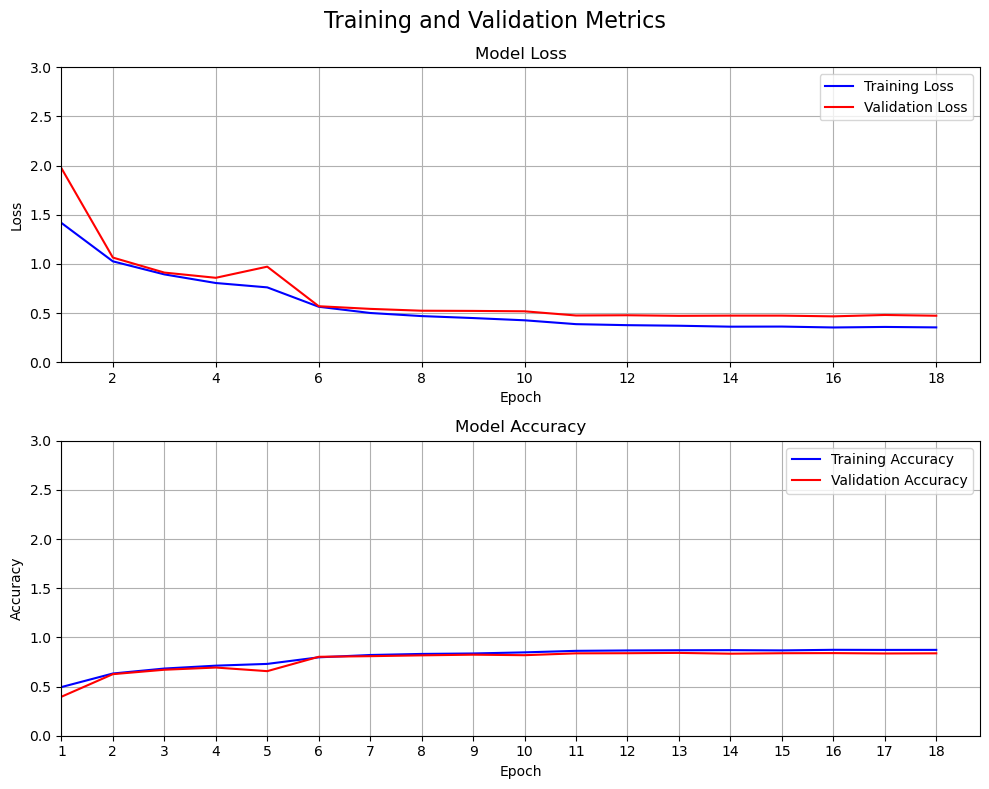

In [20]:
import matplotlib.pyplot as plt
import numpy as np

stopped_epoch = 13# best_epoch + patience

# Data from your training output
epochs = range(1, 19) ## HARD CODDED stopped_epoch
           
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Plot training & validation loss values
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 3)
ax1.set_xlim(1)
ax1.legend()
ax1.grid()


# Plot training & validation accuracy values
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 3)
ax2.set_xlim(1)
ax2.set_xticks(ticks=np.arange(1, 19, 1)) # HARD CODED, epochs
ax2.legend()
ax2.grid()

# Adjust layout and display the plot
fig.tight_layout()
ax1.plot()
ax2.plot()
fig.show()

# Calculate and print best validation accuracy
best_val_accuracy = max(val_accuracies)
best_epoch = val_accuracies.index(best_val_accuracy) + 1
print(f"Best validation accuracy: {best_val_accuracy:.4f} (Epoch {best_epoch})")

# Calculate and print final training-validation gap
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
acc_gap = final_train_acc - final_val_acc
print(f"Final accuracy gap (train - val): {acc_gap:.4f}")


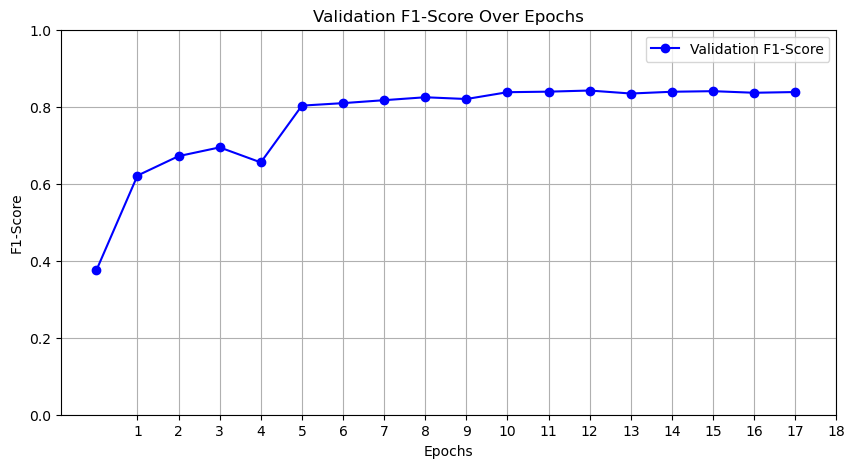

In [21]:
# Plot F1-Score
f, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax.plot(val_f1_scores, label='Validation F1-Score', marker='o', color='blue')
ax.set_xlabel('Epochs', loc='center')
ax.set_ylabel('F1-Score')
ax.set_title('Validation F1-Score Over Epochs')
ax.set_ylim(0, 1)
ax.set_xticks(ticks=np.arange(1, 19, 1)) # HARD CODED
ax.legend()
ax.grid()
f.show()

13


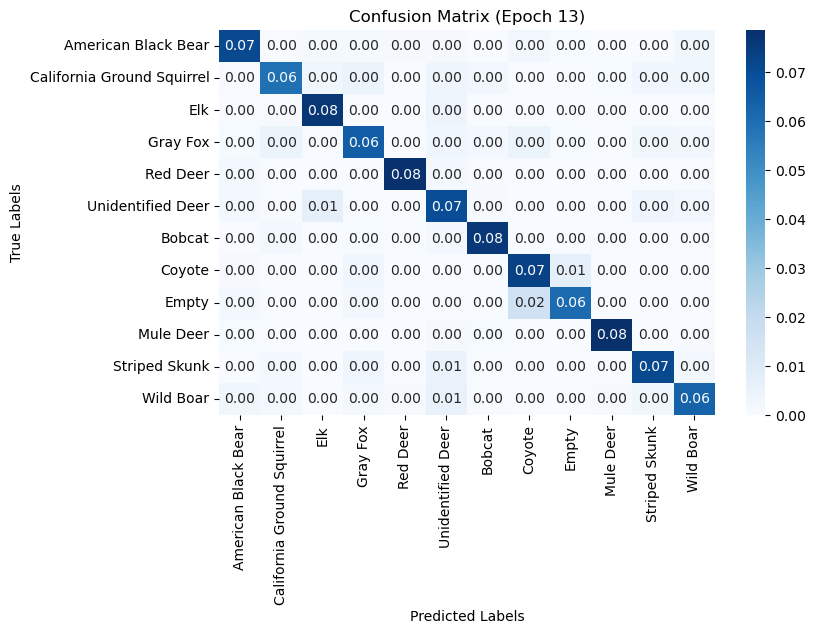

In [59]:
import seaborn as sns
print(best_epoch)
# Confusion Matrix for the Best Epoch
conf_matrix = val_conf_matrices[best_epoch - 1]  # Index corresponds to the best epoch
class_names = ['American Black Bear', 'California Ground Squirrel', 'Elk', 'Gray Fox', 'Red Deer', 'Unidentified Deer', 'Bobcat', 'Coyote', 'Empty', 'Mule Deer', 'Striped Skunk', 'Wild Boar']  # TODO CLASSES NAMES

f, ax = plt.subplots(figsize=(8, 5), sharex=True)
sns.heatmap(conf_matrix/ np.sum(conf_matrix), annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title(f'Confusion Matrix (Epoch {best_epoch})')
f.show()


In [24]:
# Plot ROC AUC (only if binary classification)
if len(val_roc_aucs) > 0:
    #plt.figure(figsize=(10, 5))
    f, ax = plt.subplots(figsize=(10, 5), sharex=True)
    
    ax.plot(val_roc_aucs, label='Validation ROC AUC', color='green')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('ROC AUC')
    ax.set_title('Validation ROC AUC Over Epochs')
    ax.legend()
    ax.grid()
    f.show()

# Use trained model REVOIR

In [ ]:
# Assuming you have a model class defined
model_path = 'best_model.pth'
model = YourModelClass()  # Replace with your model class
model.load_state_dict(torch.load(model_path))  # Load the saved weights
model.eval()  # Set the model to evaluation mode


Epoch 1/25
----------
train Loss: 1.4171 Acc: 0.4949
val Loss: 1.9741 Acc: 0.3965
Saved best model at epoch 1 with validation accuracy: 0.3965
Epoch 2/25
----------
train Loss: 1.0263 Acc: 0.6329
val Loss: 1.0647 Acc: 0.6262
Saved best model at epoch 2 with validation accuracy: 0.6262
Epoch 3/25
----------
train Loss: 0.8936 Acc: 0.6835
val Loss: 0.9120 Acc: 0.6712
Saved best model at epoch 3 with validation accuracy: 0.6712
Epoch 4/25
----------
train Loss: 0.8058 Acc: 0.7127
val Loss: 0.8589 Acc: 0.6936
Saved best model at epoch 4 with validation accuracy: 0.6936
Epoch 5/25
----------
train Loss: 0.7615 Acc: 0.7307
val Loss: 0.9722 Acc: 0.6569
Epoch 6/25
----------
train Loss: 0.5643 Acc: 0.7975
val Loss: 0.5697 Acc: 0.8030
Saved best model at epoch 6 with validation accuracy: 0.8030
Epoch 7/25
----------
train Loss: 0.5009 Acc: 0.8212
val Loss: 0.5427 Acc: 0.8092
Saved best model at epoch 7 with validation accuracy: 0.8092
Epoch 8/25
----------
train Loss: 0.4693 Acc: 0.8321
val Loss: 0.5239 Acc: 0.8177
Saved best model at epoch 8 with validation accuracy: 0.8177
Epoch 9/25
----------
train Loss: 0.4493 Acc: 0.8368
val Loss: 0.5220 Acc: 0.8245
Saved best model at epoch 9 with validation accuracy: 0.8245
Epoch 10/25
----------
train Loss: 0.4265 Acc: 0.8480
val Loss: 0.5180 Acc: 0.8193
Epoch 11/25
----------
train Loss: 0.3873 Acc: 0.8635
val Loss: 0.4755 Acc: 0.8380
Saved best model at epoch 11 with validation accuracy: 0.8380
Epoch 12/25
----------
train Loss: 0.3770 Acc: 0.8674
val Loss: 0.4779 Acc: 0.8394
Saved best model at epoch 12 with validation accuracy: 0.8394
Epoch 13/25
----------
train Loss: 0.3712 Acc: 0.8694
val Loss: 0.4720 Acc: 0.8425
Saved best model at epoch 13 with validation accuracy: 0.8425
Epoch 14/25
----------
train Loss: 0.3616 Acc: 0.8706
val Loss: 0.4741 Acc: 0.8345
Epoch 15/25
----------
train Loss: 0.3627 Acc: 0.8681
val Loss: 0.4741 Acc: 0.8392
Epoch 16/25
----------
train Loss: 0.3535 Acc: 0.8740
val Loss: 0.4667 Acc: 0.8405
Epoch 17/25
----------
train Loss: 0.3589 Acc: 0.8729
val Loss: 0.4807 Acc: 0.8366
Epoch 18/25
----------
train Loss: 0.3543 Acc: 0.8734
val Loss: 0.4730 Acc: 0.8382
Early stopping triggered after 18 epochs.
Best validation accuracy achieved at epoch 13: 0.8425
Training complete

# Testing REVOIR

In [ ]:

test_dataset = datasets.ImageFolder(data_dir='/exchange/dspro01/group3/data/test', transform=transform) # same transform as train and validation phases
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize variables to track performance on the test set
test_preds = []
test_labels = []
test_loss = 0.0
test_corrects = 0

# Evaluate the model on the test set
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Calculate loss (optional)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        # Update the number of correct predictions
        test_corrects += torch.sum(preds == labels.data)

        # Store predictions and labels for metric calculations
        test_preds.append(preds.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

# Calculate the average loss
test_loss /= len(test_loader.dataset)

# Calculate accuracy
test_accuracy = test_corrects.double() / len(test_loader.dataset)

# Calculate F1-Score, ROC AUC, and Confusion Matrix (if needed)
test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

f1 = f1_score(test_labels, test_preds, average='weighted')
conf_matrix = confusion_matrix(test_labels, test_preds)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1-Score: {f1:.4f}')
print(f'Test Confusion Matrix:\n{conf_matrix}')
